In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

生成数据公式
$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$

In [7]:
#制作人工数据集
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5 #特意将训练集做的比较小，使得容易发生过拟合
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05 #w真实值全为0.01，b为0.05
train_data = d2l.synthetic_data(true_w, true_b, n_test) #生成数据集
train_iter = d2l.load_array(train_data, batch_size) #从数组生成iterate
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [14]:
#初始化模型参数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1),requires_grad=True)#均值为0，方差为1
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

定义惩罚，这里改为使用L1范数

In [15]:
def l1_penalty(w):
    return torch.sum(torch.abs(w))#对所有元素取绝对值并求和

训练函数

In [29]:
def train(lambd):#接受超参数lambda
    w, b = init_params()#初始化参数
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss #线性回归，平方损失，lambda为匿名函数
    num_epochs, lr = 100, 0.003 #迭代数与学习率
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                           xlim=[5,num_epochs], legend=['train', 'test'])#作图
    for epoch in range(num_epochs):#训练迭代
        for X, y in train_iter:
            l = loss(net(X), y)+ lambd * l1_penalty(w)#计算损失，即原损失+正则项
            #严格地讲使用L1范数时表达式的形式不应该是这样，见练习3
            l.sum().backward()#对一个batch的损失求和后反向传播
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:#每5迭代打印一次
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                    d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L1范数是：', torch.sum(torch.abs(w)).item())

w的L1范数是： 116.36851501464844


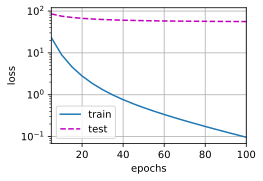

In [30]:
train(lambd=0)

使用权重衰减
可以自己多换几个$\lambda$取值看看不同效果

w的L1范数是： 0.8542037606239319


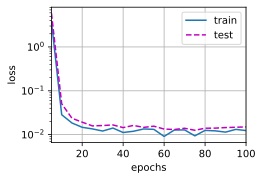

In [31]:
train(lambd=3)

简洁实现，直接使用weight_decay指定超参数，是用pytorch实现的，所以这里是L2范数。

In [24]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 8.456375122070312


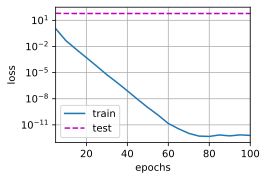

In [25]:
train_concise(0)

w的L2范数： 0.09245594590902328


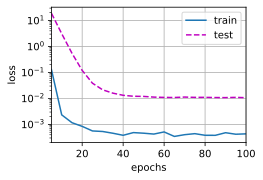

In [26]:
train_concise(3)

#### 练习（答案仅供参考）
1. 在本节的估计问题中使用$\lambda$的值进行实验。绘制训练和测试精度关于$\lambda$的函数。你观察到了什么？
<p>随lambda增大精度先降低后不收敛，

[评论区](#https://zh-v2.d2l.ai/chapter_multilayer-perceptrons/weight-decay.html)有其他同学发布的图片

2. 使用验证集来找到最佳值$\lambda$。它真的是最优值吗？这有关系吗？
<p>不能确定是否是最优值，但没关系，只要足够优即可
1. 如果我们使用$\sum_i |w_i|$作为我们选择的惩罚（$L_1$正则化），那么更新方程会是什么样子？
<p>$\frac{\partial{}}{\partial{\mathbf{w}}}(\ell(\mathbf{w},b)+\lambda||\mathbf{w}||_1)=\frac{\partial{\ell(\mathbf{w},b)}}{{\partial{\mathbf{w}}}}+\lambda I'$
<p>其中$I'=(a_1,...,a_n)$,当$\mathbf{w}$中第$i$个元素为正时$a_i=1$，反之$a_i=-1$.（=0时随意）<p>代入公式化简得$\mathbf{w}_{t+1}=\mathbf{w}_{t}-\eta\frac{\partial{\ell(\mathbf{w}_t,b_t)}}{{\partial{\mathbf{w}_{t}}}}-\eta\lambda I'$
<p>从这个式子可以看出使用L1正则化时只能对所有同号的参数施加一个相同大小的正则项（增减一个定值），而反观L2正则化对参数的影响是与参数本身的值有关的（乘上一个系数）似乎是更好的选择。不过L1正则化在特征提取上会有用处。
1. 我们知道$\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$。你能找到类似的矩阵方程吗（见 :numref:`subsec_lin-algebra-norms` 中的Frobenius范数）？<p>这个不太理解题意，可能是说对称矩阵？
1. 回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练数据、使用适当复杂度的模型之外，你还能想出其他什么方法来处理过拟合？<p>EarlyStopping等
1. 在贝叶斯统计中，我们使用先验和似然的乘积，通过公式$P(w \mid x) \propto P(x \mid w) P(w)$得到后验。如何得到带正则化的$P(w)$？

